In [1]:
# Data: http://share.mailcharts.com/3p213G2D232x
# Headers: id, company name, company id, subject, sent at, discounts

# Goal 1: When will the next email be?
# -- in [n] seconds

In [144]:
from datetime import date, datetime
import pandas as pd
import numpy as np
import re
import scipy
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.cross_validation import train_test_split 

In [96]:
df = pd.read_csv('data/companies.csv')
df.shape

(4585, 6)

In [97]:
# Add features

def determine_weekday(n):
    if n == 5 or n == 6:
        # weekend
        return 0
    else:
        #weekday
        return 1
    
def determine_am_pm(date):
    return 0 if date.strftime('%p') == "AM" else 1
    
def create_datetime(row):
    return datetime(row["year"],row["month"],row["day"])

# df["promo_not_promo"] = np.where(df["promotion_type"] == "[null]", 0, 1)
df["month"] = df["sent_at"].str.split('-').str.get(1).astype(int)
df["year"] = df["sent_at"].str.split('-').str.get(0).astype(int)
df["day"] = df["sent_at"].str.split('-').str.get(2).str.split(' ').str.get(0).astype(int)
df["weeknum"] = df.apply(lambda x: create_datetime(x).isocalendar()[1], axis=1)
df["am_pm"] = df.apply(lambda x: determine_am_pm(create_datetime(x)), axis=1)
df["weekday_weekend"] = df.apply(lambda x: determine_weekday(create_datetime(x).weekday()), axis=1)

In [98]:
# Get company dummies (we will use this later
dummy_company = pd.get_dummies(df["company_name"])

In [99]:
# Gather when the previous email was sent
## QUESTION: HOW CAN WE MAKE THIS RUN FASTER

df = df.sort_values("sent_at", ascending=False)
results = []
for index, row in df.iterrows():
    company_emails = df[df["company_id"] == row["company_id"]]
    earlier_emails = list(filter(lambda x: x < row["sent_at"], company_emails["sent_at"]))
    if len(earlier_emails) > 0:
        results.append(earlier_emails[0])
        continue
    else:
        results.append(None)

# Save the results to our dataframe
df["prev_email"] = results

In [100]:
# Get the time delta from when the previous email was sent

def construct_full_date(timestamp):
    # 2017-01-01 00:01:32
    # format: year, month, day, hour, minute, seconds
    date = re.split(" |\-|\:", timestamp)
    _date = [int(x) for x in date]
    return datetime(year=_date[0], month=_date[1], day=_date[2], hour=_date[3], minute=_date[4], second=_date[5])

def get_time_delta(a, b):
    if b == None:
        return 0
    else:
        return (construct_full_date(a) - construct_full_date(b)).total_seconds()
    
df["prev_email_delta"] = df.apply(lambda x: get_time_delta(x["sent_at"], x["prev_email"]), axis=1)

# QA that we only have 1 time_delta with a value of 0
df[df["prev_email_delta"] == 0]["company_name"].value_counts()

1-800-Flowers.com      1
Abercrombie & Fitch    1
Ace & Tate             1
AllModern              1
10DollarMall           1
A'GACI                 1
1000Bulbs.com          1
Ace & Everett          1
Allurez                1
Adorama                1
Name: company_name, dtype: int64

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4585 entries, 4584 to 0
Data columns (total 14 columns):
id                  4585 non-null int64
company_name        4585 non-null object
company_id          4585 non-null int64
subject             4585 non-null object
sent_at             4585 non-null object
industry_name       4083 non-null object
month               4585 non-null int64
year                4585 non-null int64
day                 4585 non-null int64
weeknum             4585 non-null int64
am_pm               4585 non-null int64
weekday_weekend     4585 non-null int64
prev_email          4575 non-null object
prev_email_delta    4585 non-null float64
dtypes: float64(1), int64(8), object(5)
memory usage: 537.3+ KB


In [102]:
#another way of doing this:
df['sent_time']=pd.to_datetime(df.sent_at, format='%Y/%m/%d %H:%M:%S' )

df['previous_time']=pd.to_datetime(df.prev_email, format='%Y/%m/%d %H:%M:%S'  )

df['hour']= df.sent_time.apply(lambda x: x.hour)
df['month']= df.sent_time.apply(lambda x: x.month)

df['day_of_week']=df.sent_time.dt.weekday_name 
df['day_of_week_num']=df.sent_time.dt.weekday 
df['weekend']=df.sent_time.apply(lambda x: 1 if x=='Saturday' or x=='Sunday' else  0) 
df['weekend_2']=df.weekend.apply(lambda  x: 'Weekend' if x==1 else 'Weekday')

df['time_between_two_emails']=df.sent_time-df.previous_time
df['time_between_two_emails_in_sec']=df['time_between_two_emails'] / np.timedelta64(1, 's')

In [103]:
df.head(2)

,id,company_name,company_id,subject,sent_at,industry_name,month,year,day,weeknum,...,prev_email_delta,sent_time,previous_time,hour,day_of_week,day_of_week_num,weekend,weekend_2,time_between_two_emails,time_between_two_emails_in_sec
4584,2535536,Abercrombie & Fitch,285,LAST DAY: Sale up to 40% off & 25% off your pu...,2017-10-23 11:06:10,retail,10,2017,23,43,...,17501.0,2017-10-23 11:06:10,2017-10-23 06:14:29,11,Monday,0,0,Weekday,04:51:41,17501.0
4583,2534559,Abercrombie & Fitch,285,Another adventure calling your name?,2017-10-23 06:14:29,retail,10,2017,23,43,...,68530.0,2017-10-23 06:14:29,2017-10-22 11:12:19,6,Monday,0,0,Weekday,19:02:10,68530.0


In [104]:
# Merge both dataframes
df = pd.merge(df, dummy_company, right_index=True, left_index=True)

In [105]:
df.head(2)

,id,company_name,company_id,subject,sent_at,industry_name,month,year,day,weeknum,...,1-800-Flowers.com,1000Bulbs.com,10DollarMall,A'GACI,Abercrombie & Fitch,Ace & Everett,Ace & Tate,Adorama,AllModern,Allurez
4584,2535536,Abercrombie & Fitch,285,LAST DAY: Sale up to 40% off & 25% off your pu...,2017-10-23 11:06:10,retail,10,2017,23,43,...,0,0,0,0,1,0,0,0,0,0
4583,2534559,Abercrombie & Fitch,285,Another adventure calling your name?,2017-10-23 06:14:29,retail,10,2017,23,43,...,0,0,0,0,1,0,0,0,0,0


In [106]:
# Drop the columns we don't need
df= df.drop(["subject", "sent_at", "id"], axis=1)

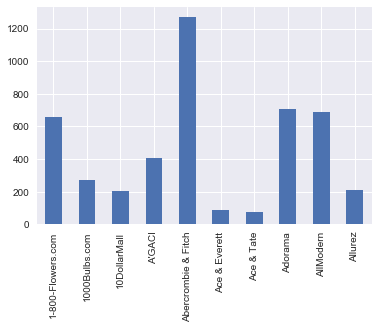

In [107]:
# Visualize the send volume to understand the data a bit better

email_counts_sum = df["company_name"].value_counts().sort_index(axis=0)
email_counts_sum.plot(kind='bar')

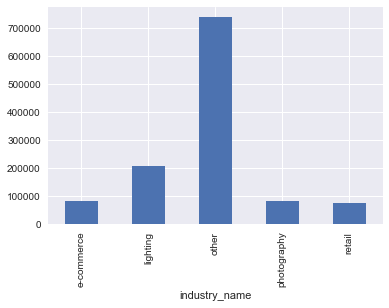

In [108]:
# Visualize the send volume to understand the data a bit better

email_between_time_avg = df.groupby(["industry_name"]).time_between_two_emails_in_sec.mean()
email_between_time_avg.plot(kind='bar')

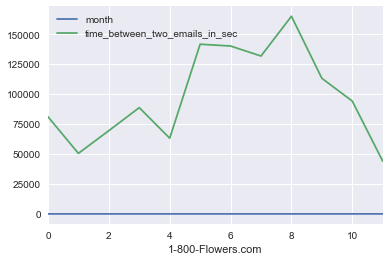

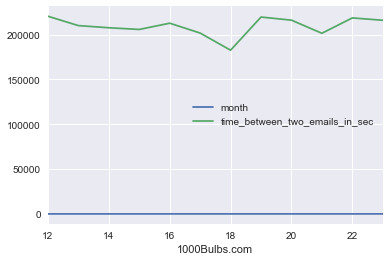

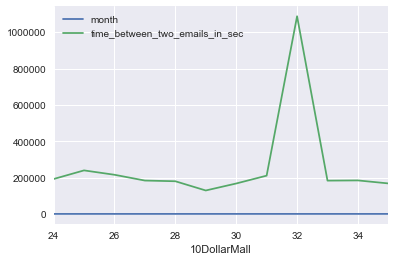

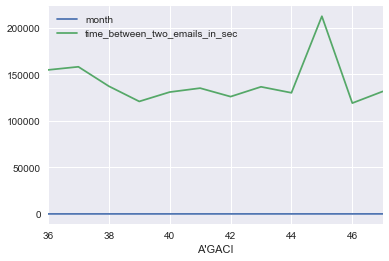

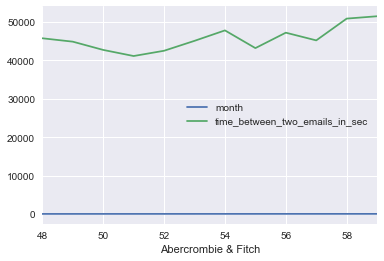

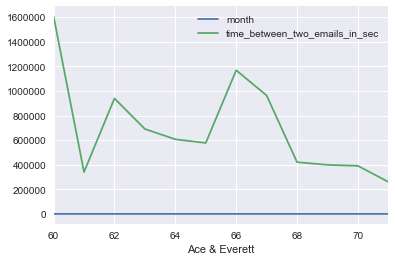

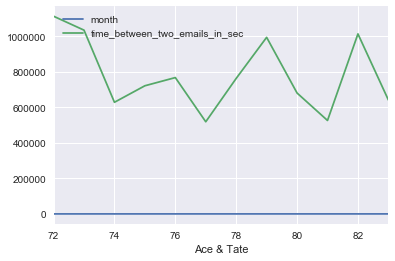

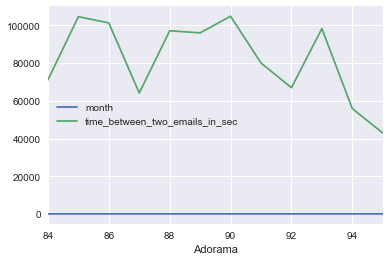

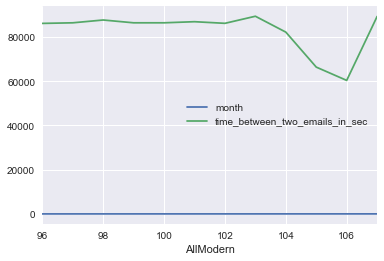

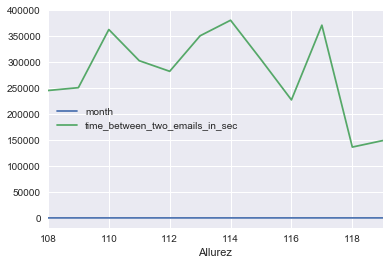

In [109]:
# Let's analyze the sending behavior of these companies
# Takeaway: They all have their own sending behavior!
# Note: Spikes == more time in between emails

time_delta_average_by_month = df.groupby(by=['company_name', 'month'])["time_between_two_emails_in_sec"].mean().reset_index()
c_id = time_delta_average_by_month["company_name"].unique()

for i in c_id:
    plot = time_delta_average_by_month[time_delta_average_by_month["company_name"] == i].plot()
    plot.set_xlabel(i)


In [110]:
# Get the time-delta for each company
df.groupby(["industry_name", "company_name"]).time_between_two_emails_in_sec.mean().reset_index().sort_values("time_between_two_emails_in_sec")

,industry_name,company_name,time_between_two_emails_in_sec
6,retail,Abercrombie & Fitch,45000.473601
3,photography,Adorama,80405.512023
0,e-commerce,AllModern,82879.405523
4,retail,1-800-Flowers.com,86921.038110
5,retail,A'GACI,139535.269608
1,lighting,1000Bulbs.com,208456.487085
2,other,Ace & Tate,738067.870130


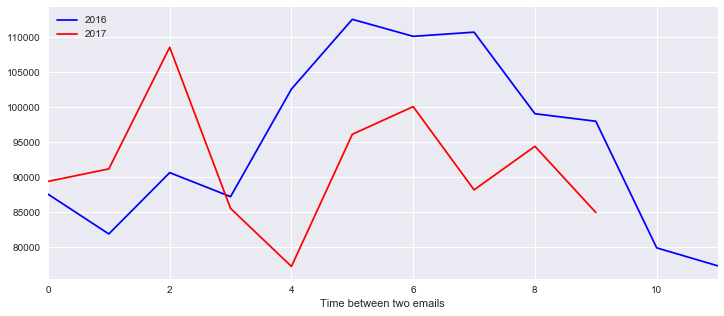

In [192]:
# Let's analyze the data by month

plt.figure(figsize=(12,5))
plt.xlabel('Time between two emails')

ax1 = df1.time_between_two_emails_in_sec.plot(color='blue',  label='2016')
ax2 = df2.time_between_two_emails_in_sec.plot(color='red',  label='2017')

h1, l1 = ax1.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1, l1, loc=2)
plt.show()


# We can definitely see the impact of seasonality

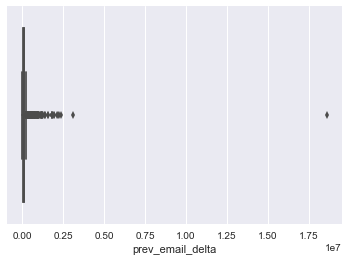

In [112]:
sns.boxplot(x=df["prev_email_delta"])
# We have some outliers! We need to remove them

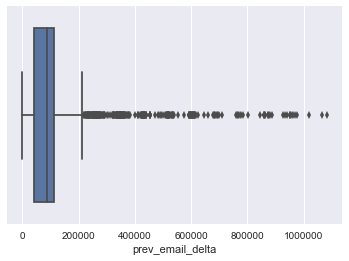

In [134]:
stdev = df.prev_email_delta.std()
mean = df.prev_email_delta.mean()
upper_bound = mean + (stdev * 3)
lower_bound = mean - (stdev * 3)

df= df[(df.prev_email_delta >=lower_bound) & (df.prev_email_delta <= upper_bound)]

sns.boxplot(x=df["prev_email_delta"])

In [174]:
df.dropna(inplace=True)
df = df.fillna(0)

/Users/koyuki.nakamori/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


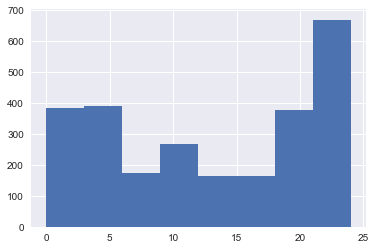

In [135]:
df["readable_time_delta"] = df["prev_email_delta"] / 60 / 60
df.readable_time_delta.hist(bins = [0, 3, 6, 9, 12, 15, 18, 21, 24])

In [118]:
#sns.pairplot(df[["weekend", "month", "company_name", "industry_name", "time_between_two_emails_in_sec"]])

In [136]:
df.weekday_weekend.unique()

array([1, 0])

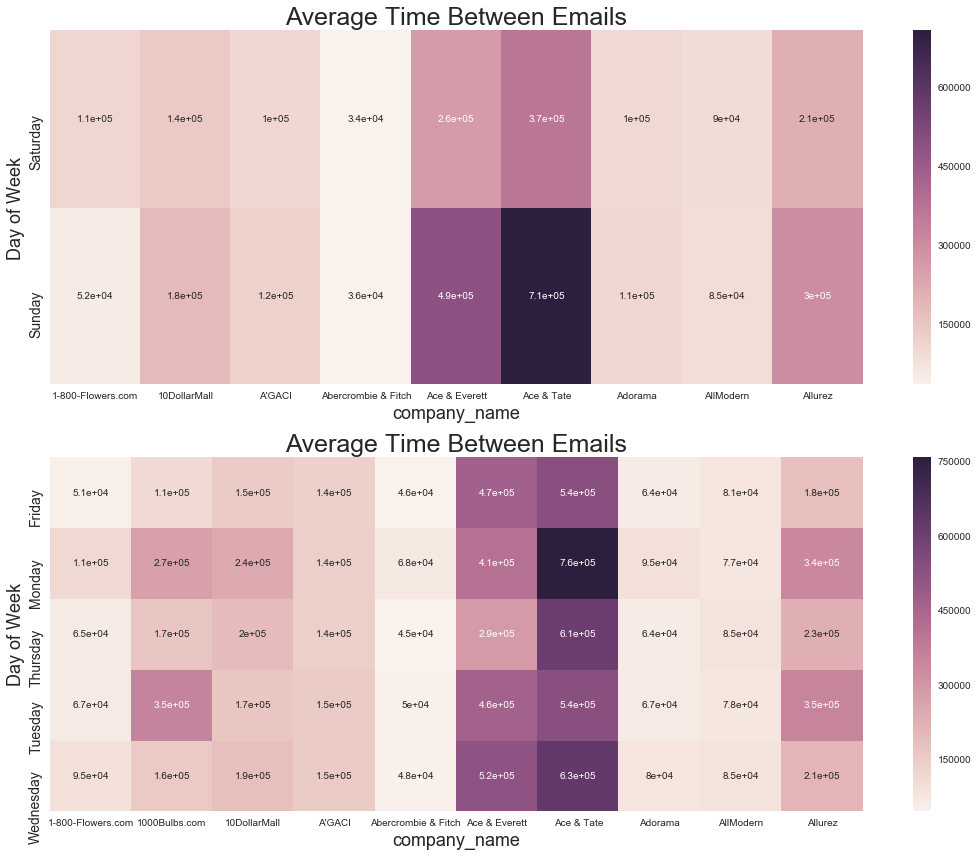

In [137]:
#heatmap
f=plt.figure(1,figsize=(15,12))
for i,weekend in enumerate([0,1]):
    pvt=pd.pivot_table(data=df[df.weekday_weekend==weekend],values='time_between_two_emails_in_sec',index='day_of_week', columns='company_name')
    ax=f.add_subplot(2,1,i+1)
    sns.heatmap(pvt,annot=True)
    plt.title('Average Time Between Emails'.format(weekend),fontsize=25)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=14)
    plt.xlabel('company_name',fontsize=18)
    plt.ylabel('Day of Week',fontsize=18)
    plt.tight_layout()
plt.show()

In [133]:
#sns.violinplot(x='month', y='time_between_two_emails_in_sec', data=df, hue='industry_name' )

In [138]:
df['retail_ecommerce']=(df.industry_name=='retail') ^  (df.industry_name=='e-commerce')

/Users/koyuki.nakamori/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [140]:
def season_map(month):
    season=''
    if month <=3:
        season='SPR'
    elif month<=6:
        season='SUM'
    elif month<=9:
        season='FAL'
    else: 
        season='HOL'
    return season 
        
    

In [141]:
df['season']=df.month.apply(lambda x:season_map(x))

/Users/koyuki.nakamori/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


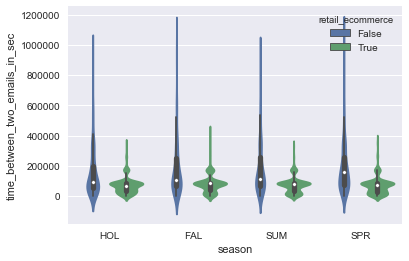

In [142]:
sns.violinplot(x='season', y='time_between_two_emails_in_sec', data=df, hue='retail_ecommerce' )

In [146]:
df['season_num']= pd.Categorical(df.season).codes

Features we want:

- Month
- Company
- Industry
- am_pm
- weekend

Models:

- linear regression
- decision tree regressor

Homework:

- Remove outliers
- Clean up code and comment it

## Homework
- [x] Average time delta for each company.
  - [x] Same for average time by month.
- [x] Get more historical data. Look at seasonality by month.
- [x] Fix promotional / not promotional.
- Look at outliers
- [x] Add company tags / categories

## Models to use – brainstorm
**Question: When will the next email be?**

- Linear regression

**Will the next email be a discount?**

- Random forrest (DecisionTreeClassifier)

**How much will they discount by?**

- SVM

In [175]:
# Modelling 

target=df.time_between_two_emails_in_sec
features= df[['season_num', 'weekday_weekend', 'retail_ecommerce']]
X_train, X_test, y_train, y_test= train_test_split(features, target)

In [176]:
lg= LinearRegression()

In [177]:
lg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [178]:
y_pred=lg.predict(X_test)

In [179]:
lg.score(X_test, y_test)

0.11466656352279324